# <span style="color:purple"> Week 8 - Semantic Network
### <span style="color:purple">Reuters Newspaper</span>  
<span style="color:purple">-- File: Jingying (Jane) Bi Homework 8 <br>
-- Name: Jingying Bi <br>
-- UCID: 12174556 <br>
<br>
    
<span style="color:purple">**Research Object: ** <br>
Compare the Reuters news from three classes, economy, environment, entertainment -- in terms of their underlying networks. Capture some key topological characteristics of networks.

<span style="color:purple">**Method: ** <br>
(1)  Document-Document and Word-Word Networks Visualization  <br>
(2)  POS network<br>
(3)  INteractive <br>
       
<span style="color:purple">**Dataset:** <br>
<span style="color:purple"> In this assignment, I use 2017 Reuters News from Oct ~ Dec 2008. Each news on Reuters has a tag marked by the website. I utilize these tags to create three classes. Class *Economy* includes tags "private equity", "global market", and "company". Class *Entertainment* includes tags "art", "film", and "entertainment". Class *Environment* includes tag "environment". 2017 Reuters news have been divided into 1468 *Economy* news, 348 *Entertainment* news and 201 *Environment* news. <br>
In my analysis below, I take out 10 news from each of class. <br>
    

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

<span style="color:purple"> To generate more interesting results, I discuss fours cases here, namely economy, environment, entertainment, and the mix of thes three. Comparation and contrast allow me to learn how the text networks of the three sectors are different from each other. And, also how each of the network contrasts with the mix network.  <br>
I take 6 articles from each vector, the Mix dataframe conve all the 18 articles. <br>
    
<span style="color:purple"> **Interesting Findings: **<br>
Economy has less nodes but more edges. This indicate that the words are well related with each other. They may be used at the similar time, under similar conditions. In contrast, the network of environment and entertainment are more deversified (more nodes) and less related (less edges). This could be explained by the diversification of the two sectors. You may ask, Economy sectors should also have good jobs and even more!  

### <span style="color:purple"> 1.1 Load Corpus

In [2]:
# load data
ReutersDF = pandas.read_csv('Reuters_2017News.csv')
ReutersDF[:3]

,Unnamed: 0,Year,Month,Day,Title,Topic,News,Link
0,0,2008,12,1,"Earthquake rattles Taiwan, no reports of damage",environment,Reuters Staff1 Min ReadTAIPEI (Reuters) - An e...,http://www.reuters.com/article/environmentNews...
1,1,2008,12,1,TREASURIES-Rise in Asia after Bernanke talks o...,economy,Reuters Staff3 Min Read * Treasuries edge up i...,http://www.reuters.com/article/companyNewsAndP...
2,2,2008,12,1,GLOBAL MARKETS-Asia stocks slide as global out...,economy,Reuters Staff4 Min Read * Asian shares fall 3-...,http://www.reuters.com/article/companyNewsAndP...


In [3]:
# grab 6 News in category "Economy", "Environment", "Entertainment"
Reuters_Economy = ReutersDF[ReutersDF['Topic']=='economy'][0:6]
Reuters_Environment = ReutersDF[ReutersDF['Topic']=='environment'][0:6]
Reuters_Entertainment = ReutersDF[ReutersDF['Topic']=='entertainment'][0:6]
Reuters_Mix = pandas.concat([Reuters_Economy,Reuters_Environment,Reuters_Entertainment], axis=0)

# tokenize sentences then tokenize words in each tokenized sentence
#Reuters_Economy['tokenized_sentences'] = Reuters_Economy['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Economy['tokenized_sentences'] = Reuters_Economy['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Environment['tokenized_sentences'] = Reuters_Environment['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Entertainment['tokenized_sentences'] = Reuters_Entertainment['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Mix['tokenized_sentences'] = Reuters_Mix['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

Reuters_Economy['normalized_sentences'] = Reuters_Economy['tokenized_sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])
Reuters_Environment['normalized_sentences'] = Reuters_Environment['tokenized_sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])
Reuters_Entertainment['normalized_sentences'] = Reuters_Entertainment['tokenized_sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])
Reuters_Mix['normalized_sentences'] = Reuters_Mix['tokenized_sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [4]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [5]:
g_Economy = wordCooccurrence(Reuters_Economy['normalized_sentences'][:100].sum())
g_Environment = wordCooccurrence(Reuters_Environment['normalized_sentences'][:100].sum())
g_Entertainment = wordCooccurrence(Reuters_Entertainment['normalized_sentences'][:100].sum())
g_Mix = wordCooccurrence(Reuters_Mix['normalized_sentences'][:100].sum())

In [6]:
len(g_Economy.nodes)

457

In [52]:
len(g_Environment.nodes)

655

In [53]:
len(g_Entertainment.nodes)

712

In [54]:
len(g_Mix.nodes)

1440

In [55]:
len(g_Economy.edges)

9200

In [56]:
len(g_Environment.edges)

7729

In [57]:
len(g_Entertainment.edges)

9563

In [58]:
len(g_Mix.edges)

26025

### <span style="color:purple"> Visualize the Text Network
<span style="color:purple">To visualize the network. The economy case has a wider span over the x values. While the other two stands at some x values with some outliers. Combining these observations, we find that these features have been covered by the PHD students' work. 

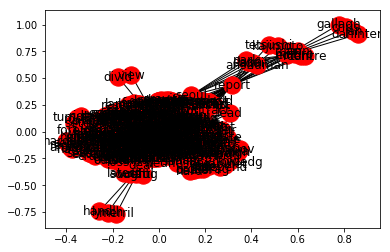

In [59]:
nx.draw_networkx(g_Economy)
plt.savefig("Reuters_Economy.png")

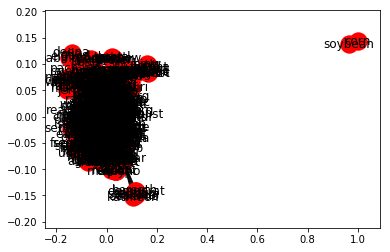

In [60]:
nx.draw_networkx(g_Environment)
plt.savefig("Reuters_Environment.png")

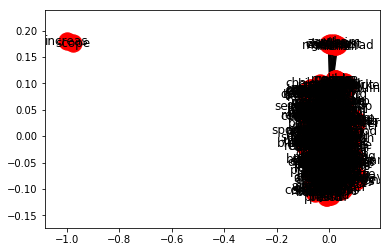

In [61]:
nx.draw_networkx(g_Entertainment)
plt.savefig("Reuters_Entertainment.png")

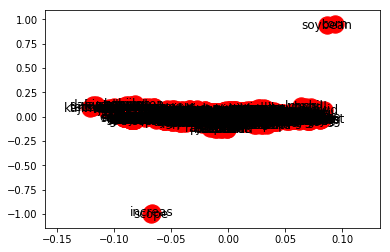

In [62]:
nx.draw_networkx(g_Mix)
plt.savefig("Reuters_Mix.png")

In [7]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [8]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence_Economy = senVectorizer.fit_transform(Reuters_Economy['News'])
senVects_incidence_Environment = senVectorizer.fit_transform(Reuters_Environment['News'])
senVects_incidence_Entertainment = senVectorizer.fit_transform(Reuters_Entertainment['News'])
senVects_incidence_Mix = senVectorizer.fit_transform(Reuters_Mix['News'])

Name: 
Type: Graph
Number of nodes: 463
Number of edges: 699
Average degree:   3.0194


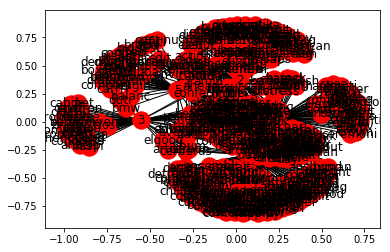

In [9]:
g_2mode_Economy = nx.Graph()

#define all the nodes
g_2mode_Economy.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence_Economy.shape[1])), bipartite = 'word')
g_2mode_Economy.add_nodes_from(range(senVects_incidence_Economy.shape[0]), bipartite = 'doc')
#add all the edges
g_2mode_Economy.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence_Economy[d, w]}) for d, w in zip(*senVects_incidence_Economy.nonzero())))

print(nx.info(g_2mode_Economy))

nx.draw_networkx(g_2mode_Economy)

Name: 
Type: Graph
Number of nodes: 661
Number of edges: 795
Average degree:   2.4054


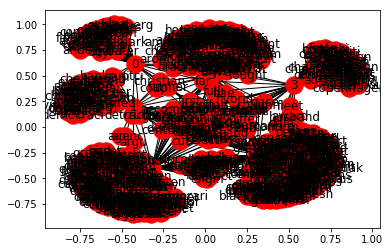

In [10]:
g_2mode_Environment = nx.Graph()

#define all the nodes
g_2mode_Environment.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence_Environment.shape[1])), bipartite = 'word')
g_2mode_Environment.add_nodes_from(range(senVects_incidence_Environment.shape[0]), bipartite = 'doc')
#add all the edges
g_2mode_Environment.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence_Environment[d, w]}) for d, w in zip(*senVects_incidence_Environment.nonzero())))

print(nx.info(g_2mode_Environment))

nx.draw_networkx(g_2mode_Environment)

Name: 
Type: Graph
Number of nodes: 718
Number of edges: 1050
Average degree:   2.9248


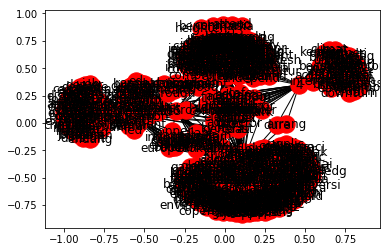

In [11]:
g_2mode_Entertainment = nx.Graph()

#define all the nodes
g_2mode_Entertainment.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence_Entertainment.shape[1])), bipartite = 'word')
g_2mode_Entertainment.add_nodes_from(range(senVects_incidence_Entertainment.shape[0]), bipartite = 'doc')
#add all the edges
g_2mode_Entertainment.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence_Entertainment[d, w]}) for d, w in zip(*senVects_incidence_Entertainment.nonzero())))

print(nx.info(g_2mode_Entertainment))

nx.draw_networkx(g_2mode_Entertainment)

Name: 
Type: Graph
Number of nodes: 1458
Number of edges: 2544
Average degree:   3.4897


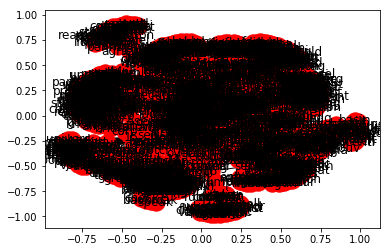

In [16]:
g_2mode_Mix = nx.Graph()

#define all the nodes
g_2mode_Mix.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence_Mix.shape[1])), bipartite = 'word')
g_2mode_Mix.add_nodes_from(range(senVects_incidence_Mix.shape[0]), bipartite = 'doc')
#add all the edges
g_2mode_Mix.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence_Mix[d, w]}) for d, w in zip(*senVects_incidence_Mix.nonzero())))

print(nx.info(g_2mode_Mix))

nx.draw_networkx(g_2mode_Mix)

### <span style="color:purple"> Document-to-Document Network
<span style="color:purple"> The networks graphs show that the documents in each area are well related to each other. Hence it yields three complete graph!<br>
On the other hand, the mix network has more holes. This is intuitive. Articles come from the same sector definitely inherent the interesting and updated qustion topics to discuss.  

In [26]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [27]:
gDoc_Economy = contractNetwork(g_2mode_Economy, 'doc')
# Document to document network
print(nx.info(gDoc_Economy))

Name: 
Type: Graph
Number of nodes: 6
Number of edges: 15
Average degree:   5.0000


In [28]:
gDoc_Environment = contractNetwork(g_2mode_Environment, 'doc')
# Document to document network
print(nx.info(gDoc_Environment))

Name: 
Type: Graph
Number of nodes: 6
Number of edges: 15
Average degree:   5.0000


In [29]:
gDoc_Entertainment = contractNetwork(g_2mode_Entertainment, 'doc')
# Document to document network
print(nx.info(gDoc_Entertainment))

Name: 
Type: Graph
Number of nodes: 6
Number of edges: 15
Average degree:   5.0000


In [30]:
gDoc_Mix = contractNetwork(g_2mode_Mix, 'doc')
# Document to document network
print(nx.info(gDoc_Mix))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 153
Average degree:  17.0000


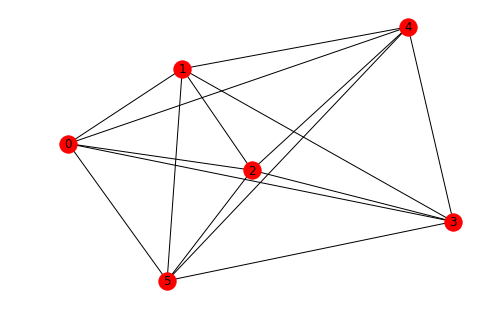

In [31]:
layout = nx.spring_layout(gDoc_Economy, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_Economy, pos = layout, labels = {n:n for n in gDoc_Economy.nodes()}) #Getting labels is a bit annoying

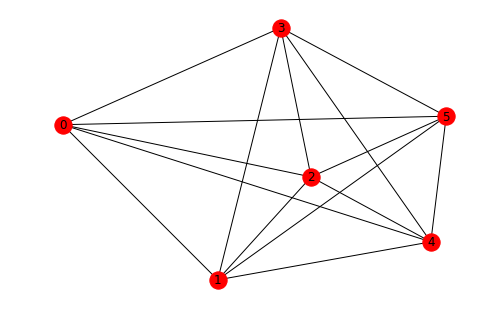

In [32]:
layout = nx.spring_layout(gDoc_Environment, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_Environment, pos = layout, labels = {n:n for n in gDoc_Environment.nodes()}) #Getting labels is a bit annoying

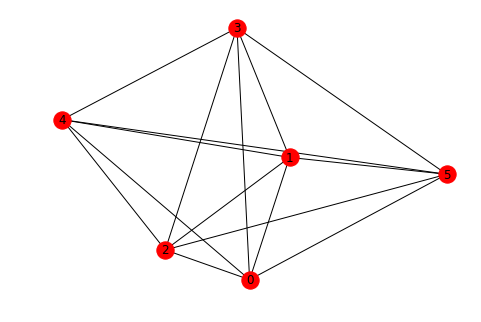

In [33]:
layout = nx.spring_layout(gDoc_Entertainment, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_Entertainment, pos = layout, labels = {n:n for n in gDoc_Entertainment.nodes()}) #Getting labels is a bit annoying

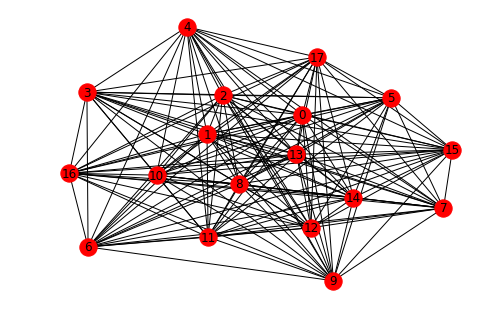

In [34]:
layout = nx.spring_layout(gDoc_Mix, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_Mix, pos = layout, labels = {n:n for n in gDoc_Mix.nodes()}) #Getting labels is a bit annoying

### <span style="color:purple"> Word-to-Word Network
<span style="color:purple"> The networks are interesting. <br>
The economy network has a relatively large component at the center. But the nodes at the center position in environment and entertainment networks, are sparse. Instead, they have heavier component locaing at the perephary. For all these three networks, the clinques are not perfectly isolated with each other. The do exist many nodes connecting different components. In contrast, the mis network tends to have clear cut among the components. 

In [35]:
gWord_Economy = contractNetwork(g_2mode_Economy, 'word')
print(nx.info(gWord_Economy))

Name: 
Type: Graph
Number of nodes: 457
Number of edges: 48676
Average degree: 213.0241


In [36]:
gWord_Environment = contractNetwork(g_2mode_Environment, 'word')
print(nx.info(gWord_Environment))

Name: 
Type: Graph
Number of nodes: 655
Number of edges: 65452
Average degree: 199.8534


In [37]:
gWord_Entertainment = contractNetwork(g_2mode_Entertainment, 'word')
print(nx.info(gWord_Entertainment))

Name: 
Type: Graph
Number of nodes: 712
Number of edges: 96224
Average degree: 270.2921


In [87]:
gWord_Mix = contractNetwork(g_2mode_Mix, 'word')
print(nx.info(gWord_Mix))

Name: 
Type: Graph
Number of nodes: 1440
Number of edges: 200488
Average degree: 278.4556


In [88]:
# Reduce the word dimensionality
wMean_Economy = np.mean([d['weight'] for n1, n2, d in gWord_Economy.edges(data = True)])

1.136884707042485

In [89]:
# Reduce the word dimensionality
wMean_Environment = np.mean([d['weight'] for n1, n2, d in gWord_Environment.edges(data = True)])
wMean_Environment

1.0261871294994804

In [90]:
# Reduce the word dimensionality
wMean_Entertainment = np.mean([d['weight'] for n1, n2, d in gWord_Entertainment.edges(data = True)])
wMean_Entertainment

1.2509561024276687

In [91]:
# Reduce the word dimensionality
wMean_Mix = np.mean([d['weight'] for n1, n2, d in gWord_Mix.edges(data = True)])
wMean_Mix

1.2114291129643668

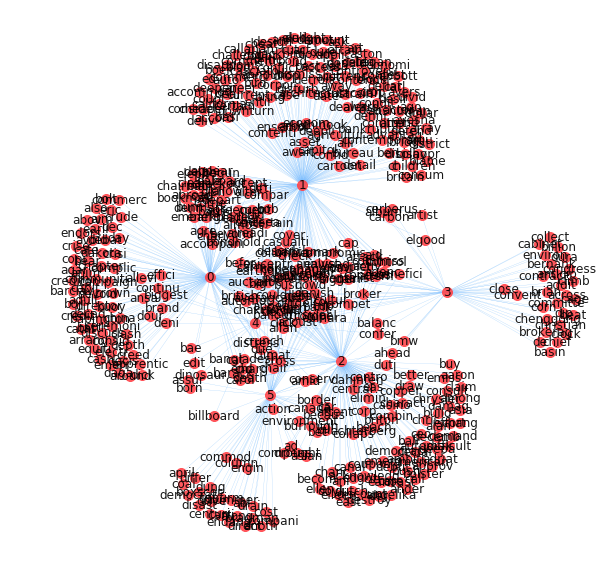

In [12]:
giant_Economy = max(nx.connected_component_subgraphs(g_2mode_Economy), key=len)

layout = nx.spring_layout(giant_Economy, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_Economy, ax = ax, pos = layout, labels = {n:n for n in giant_Economy.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

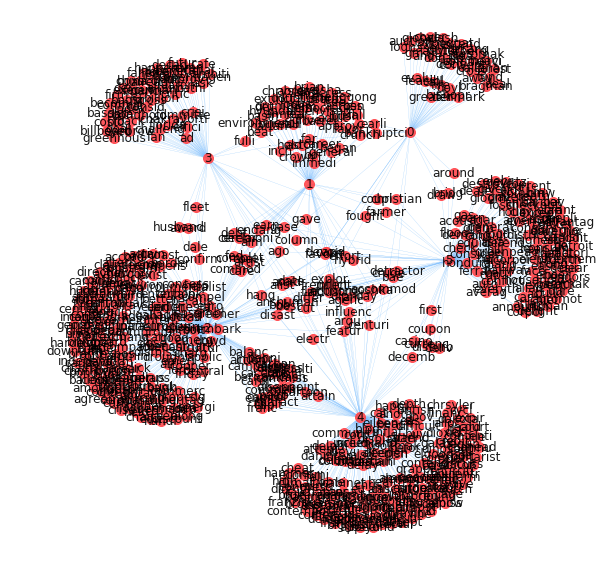

In [13]:
giant_Environment = max(nx.connected_component_subgraphs(g_2mode_Environment), key=len)

layout = nx.spring_layout(giant_Environment, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_Environment, ax = ax, pos = layout, labels = {n:n for n in giant_Environment.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

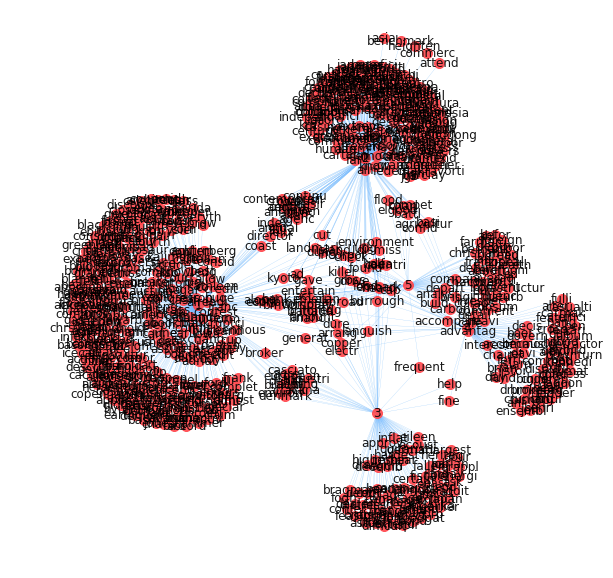

In [14]:
giant_Entertainment = max(nx.connected_component_subgraphs(g_2mode_Entertainment), key=len)

layout = nx.spring_layout(giant_Entertainment, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_Entertainment, ax = ax, pos = layout, labels = {n:n for n in giant_Entertainment.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

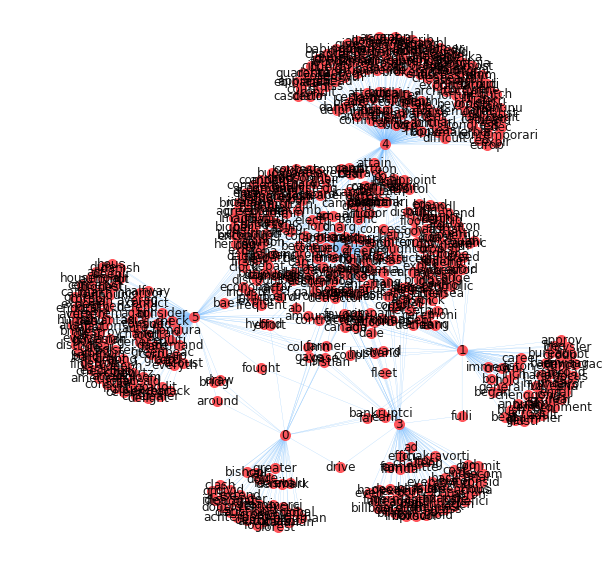

In [17]:
giant_Mix = max(nx.connected_component_subgraphs(g_2mode_Mix), key=len)

layout = nx.spring_layout(giant_Environment, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_Environment, ax = ax, pos = layout, labels = {n:n for n in giant_Environment.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

### <span style="color:purple"> Network Statistics

In [18]:
dcentralities_Economy = nx.degree_centrality(giant_Economy)

In [19]:
dcentralities_Environment = nx.degree_centrality(giant_Environment)

In [20]:
dcentralities_Entertainment = nx.degree_centrality(giant_Entertainment)

In [21]:
dcentralities_Mix = nx.degree_centrality(giant_Mix)

In [104]:
max(dcentralities_Economy.items(), key = lambda x : x[1])

(1, 0.5)

In [105]:
max(dcentralities_Environment.items(), key = lambda x : x[1])

(2, 0.3575757575757576)

In [106]:
max(dcentralities_Entertainment.items(), key = lambda x : x[1])

(1, 0.4909344490934449)

In [103]:
max(dcentralities_Mix.items(), key = lambda x : x[1])

(13, 0.24159231297185998)

### <span style="color:purple"> Betweenness Centrality

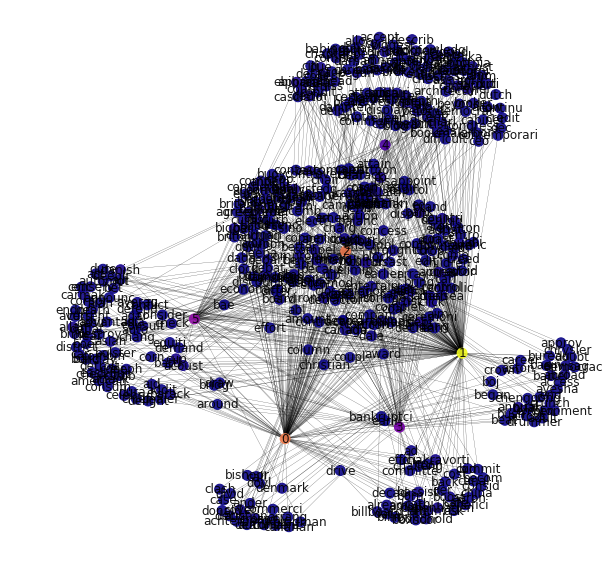

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_Economy.items(), key = lambda x : x[1])[1]
nx.draw(giant_Economy, ax = ax, pos = layout, labels = {n:n for n in giant_Economy.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_Economy[n] / maxC for n in giant_Economy.nodes],
        cmap = plt.get_cmap('plasma')) 

### The distrubution of degree centrality is

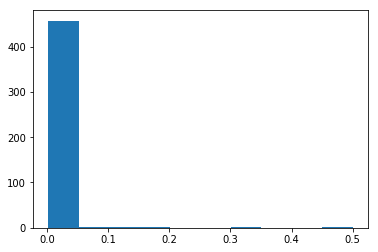

In [114]:
plt.hist(list(dcentralities_Economy.values()))
plt.show()

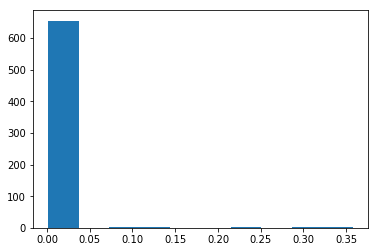

In [115]:
plt.hist(list(dcentralities_Environment.values()))
plt.show()

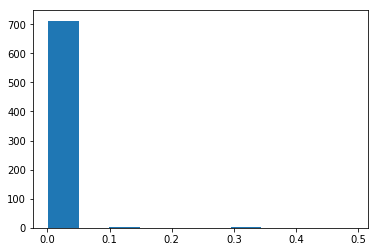

In [116]:
plt.hist(list(dcentralities_Entertainment.values()))
plt.show()

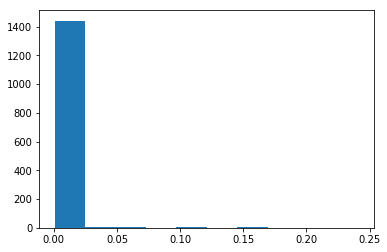

In [117]:
plt.hist(list(dcentralities_Mix.values()))
plt.show()

### The top ten words in terms of degree

In [118]:
sorted(dcentralities_Economy.items(), key = lambda x: x[1], reverse = True)[:10]

[(1, 0.5),
 (0, 0.341991341991342),
 (2, 0.33766233766233766),
 (5, 0.15151515151515152),
 (3, 0.11688311688311688),
 (4, 0.06493506493506493),
 ('bank', 0.012987012987012988),
 ('debt', 0.012987012987012988),
 ('ebihara', 0.012987012987012988),
 ('cup', 0.012987012987012988)]

In [119]:
sorted(dcentralities_Environment.items(), key = lambda x: x[1], reverse = True)[:10]

[(2, 0.3575757575757576),
 (4, 0.3196969696969697),
 (5, 0.21666666666666667),
 (1, 0.11818181818181818),
 (3, 0.11515151515151516),
 (0, 0.07727272727272727),
 ('favorit', 0.00909090909090909),
 ('devoid', 0.00909090909090909),
 ('cap', 0.00909090909090909),
 ('fiat', 0.00909090909090909)]

In [120]:
sorted(dcentralities_Entertainment.items(), key = lambda x: x[1], reverse = True)[:10]

[(1, 0.4909344490934449),
 (2, 0.30683403068340304),
 (0, 0.29707112970711297),
 (3, 0.15202231520223153),
 (4, 0.11715481171548117),
 (5, 0.100418410041841),
 ('drive', 0.008368200836820083),
 ('food', 0.008368200836820083),
 ('gave', 0.008368200836820083),
 ('gross', 0.00697350069735007)]

In [122]:
sorted(dcentralities_Mix.items(), key = lambda x: x[1], reverse = True)[:10]

[(13, 0.24159231297185998),
 (8, 0.16197666437886066),
 (1, 0.1585449553877831),
 (14, 0.15099519560741248),
 (12, 0.14619080301990392),
 (10, 0.1448181194234729),
 (0, 0.10844200411805079),
 (2, 0.10706932052161976),
 (11, 0.09814687714481811),
 (15, 0.07481125600549073)]

In [41]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [43]:
giant_Economy_filtered30 = filterWords(giant_Economy, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_Economy_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 34
Average degree:   2.7200


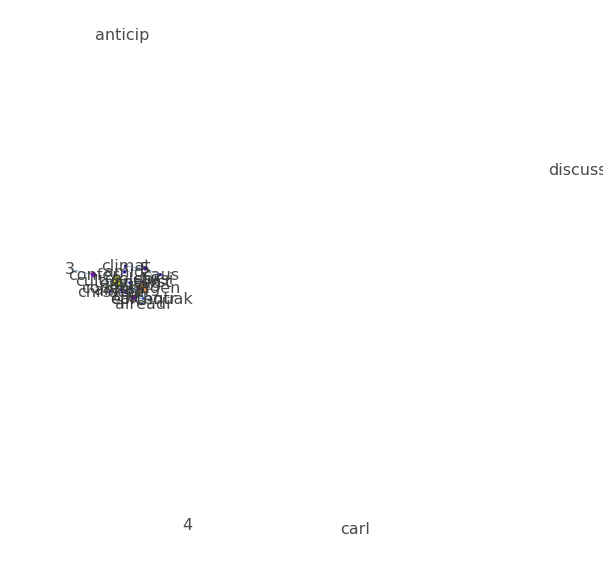

In [49]:
layout_giant_Economy_filtered30 = nx.spring_layout(giant_Economy_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_Economy_giant30 = nx.betweenness_centrality(giant_Economy_filtered30)
maxC = max(centralities_Economy_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_Economy_filtered30, ax = ax, pos = layout_giant_Economy_filtered30, labels = {n: n for n in giant_Economy_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_Economy_giant30[n] / maxC for n in giant_Economy_filtered30.nodes],
        node_size = [centralities_Economy_giant30[n] / maxC * 100 for n in giant_Economy_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

## <span style="color:purple"> POS Network

In [52]:
Reuters_Economy[0:2]

,Unnamed: 0,Year,Month,Day,Title,Topic,News,Link,tokenized_sentences,normalized_sentences
1,1,2008,12,1,TREASURIES-Rise in Asia after Bernanke talks o...,economy,Reuters Staff3 Min Read * Treasuries edge up i...,http://www.reuters.com/article/companyNewsAndP...,"[[Reuters, Staff3, Min, Read, *, Treasuries, e...","[[reuter, min, read, treasuri, edg, asia, rall..."
2,2,2008,12,1,GLOBAL MARKETS-Asia stocks slide as global out...,economy,Reuters Staff4 Min Read * Asian shares fall 3-...,http://www.reuters.com/article/companyNewsAndP...,"[[Reuters, Staff4, Min, Read, *, Asian, shares...","[[reuter, min, read, asian, share, fall, pct, ..."


In [54]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [58]:
gNN_Economy = posCooccurrence(Reuters_Economy['normalized_sentences'].sum(), 'NN')
print(nx.info(gNN_Economy))

Name: 
Type: Graph
Number of nodes: 289
Number of edges: 3046
Average degree:  21.0796


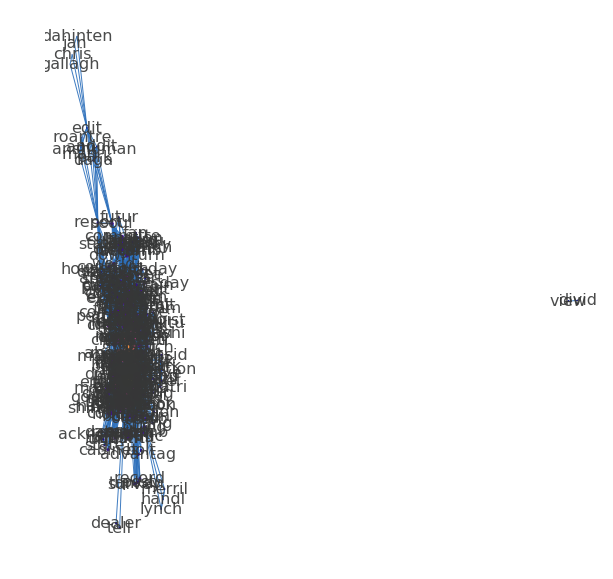

In [59]:
layout_nn = nx.spring_layout(gNN_Economy, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN_Economy)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN_Economy.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN_Economy.edges(data = True)))
nx.draw(gNN_Economy, ax = ax, pos = layout_nn, labels = {n: n for n in gNN_Economy.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN_Economy.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN_Economy.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN_Economy.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [63]:
gNV_Mix = posCooccurrence(Reuters_Economy['normalized_sentences'].sum(), 'NN', 'VB')
print(nx.info(gNV_Mix))  

Name: 
Type: Graph
Number of nodes: 303
Number of edges: 3413
Average degree:  22.5281


In [65]:
gNV_Mix.remove_edges_from([(n1, n2) for n1, n2, d in gNV_Mix.edges(data = True) if d['weight'] <= 2])
gNV_Mix.remove_nodes_from([n for n in gNV_Mix.nodes if len(set(gNV_Mix.neighbors(n))) <= 5])

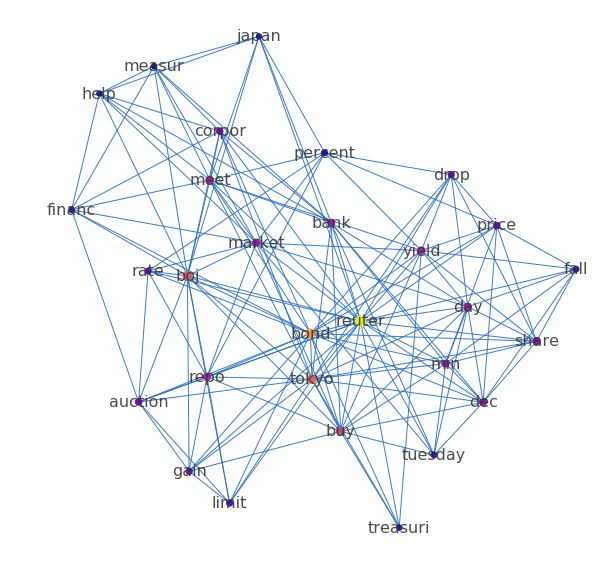

In [66]:
layout_nn = nx.spring_layout(gNV_Mix, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV_Mix)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_Mix.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_Mix.edges(data = True)))
nx.draw(gNV_Mix, ax = ax, pos = layout_nn, labels = {n: n for n in gNV_Mix.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV_Mix.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV_Mix.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

In [88]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

In [89]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['father', 'mother', 'brother','sister','grandfather','uncle','auntie']))
    faketokens = [fakeEnglish(length = 6) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*3-np.random.random()) # start time
    dt.append(i*2-1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,sister,"[alhhej, gcbjdj, gcbsel, daaksj, hgaeia, shekg...",-0.311594,-0.617749
1,father,"[fbdjch, gkdgjc, ijbaej, ckhcsa, fleiis, hciga...",2.713129,1.635956


In [91]:
output_fname = 'MyFamily.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/MyFamily/MyFamily.xml


0

In [93]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

<span style="color:purple"><span style="color:purple">*----------------END----------------* <br>
<span style="color:purple">At Regenstein Library <br>
<span style="color:purple">Jingying Bi <br>